In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score
)
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.read_csv("heart.csv")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [5]:
df=pd.read_csv("heart.csv")
print("Loaded:", df.shape)
display(df.head())

Loaded: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [6]:
# --- Identify target column (common names then binary column) ---
target_candidates = ["target", "Target", "output", "y", "disease", "heartdisease", "hd"]
target_col = None
for t in target_candidates:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    for col in df.columns:
        if df[col].dropna().isin([0,1]).all() and df[col].nunique() == 2:
            target_col = col
            break
if target_col is None:
    target_col = df.columns[-1]
print("Using target:", target_col)
print(df[target_col].value_counts())

Using target: target
target
1    526
0    499
Name: count, dtype: int64


In [7]:
# --- EDA: missing, stats, histograms, boxplots, correlations ---
print("Missing values:\n", df.isna().sum())
display(df.describe().T)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


# Visualization

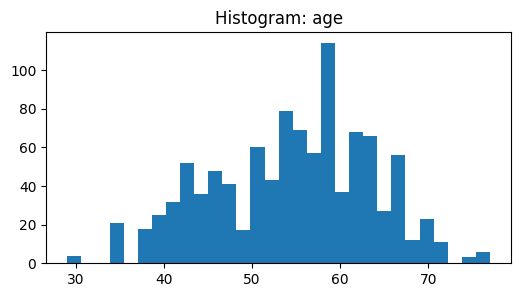

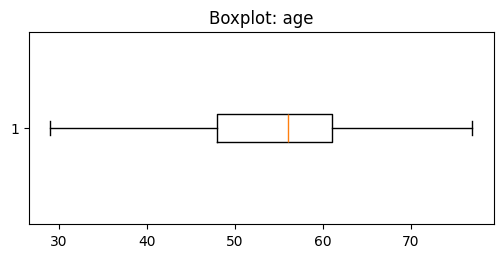

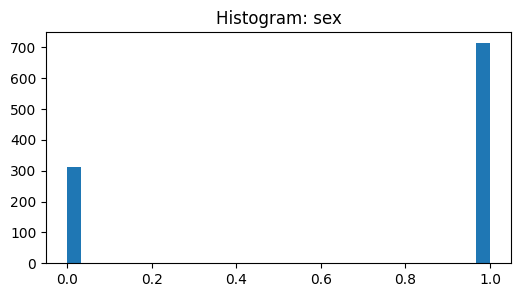

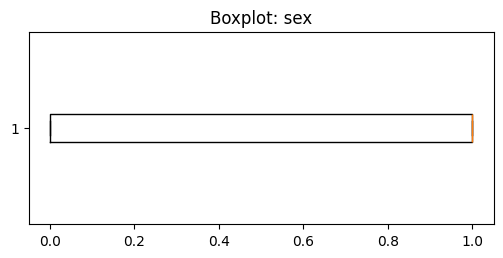

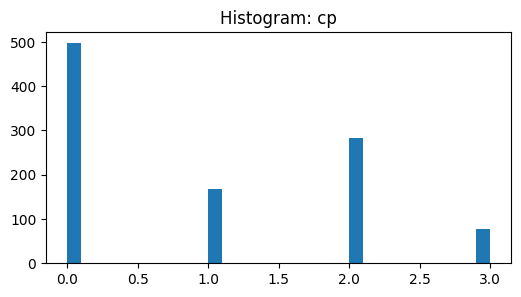

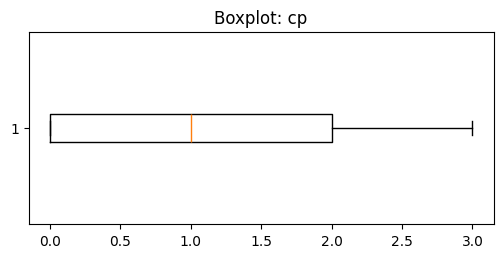

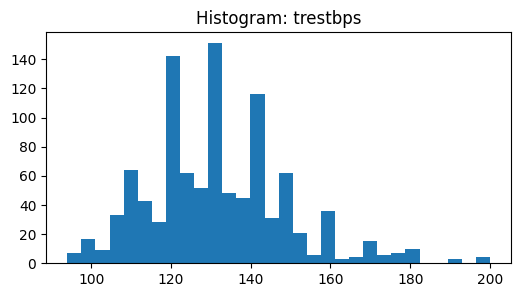

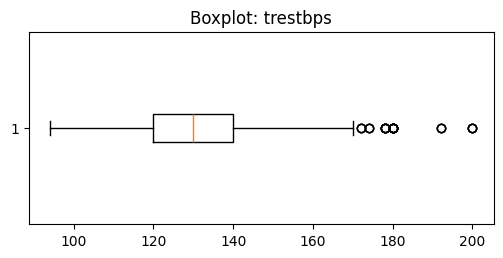

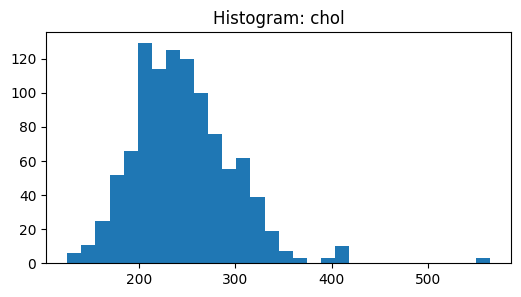

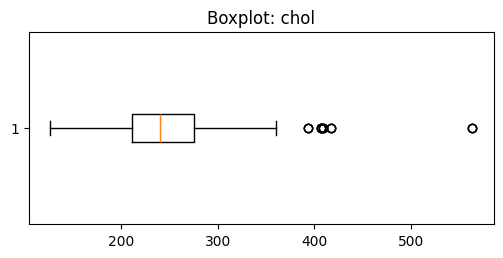

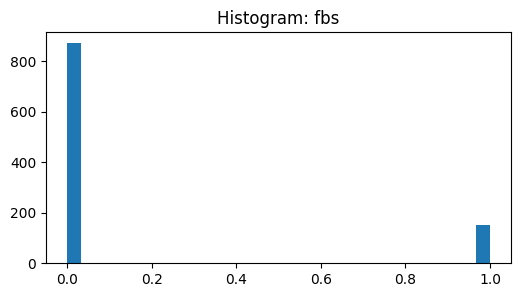

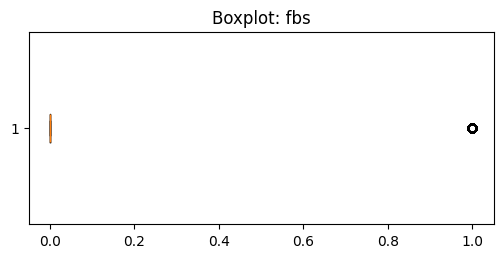

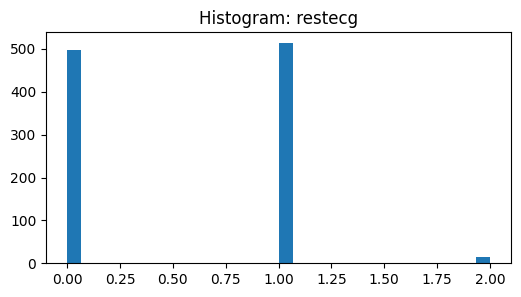

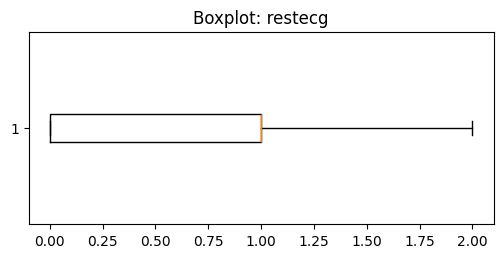

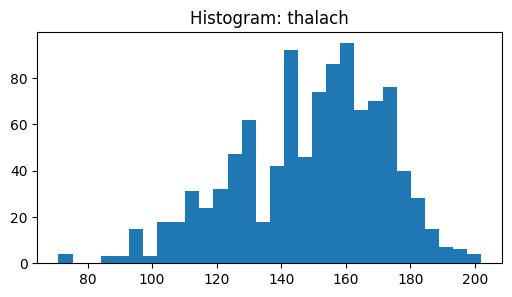

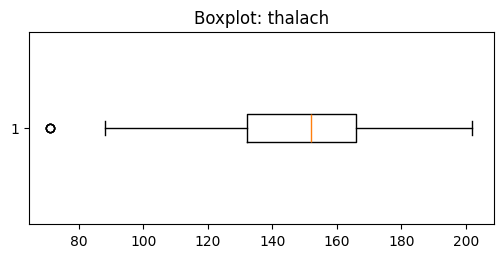

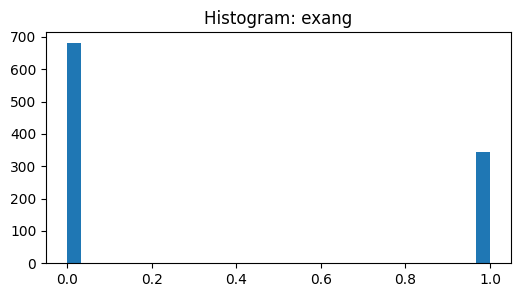

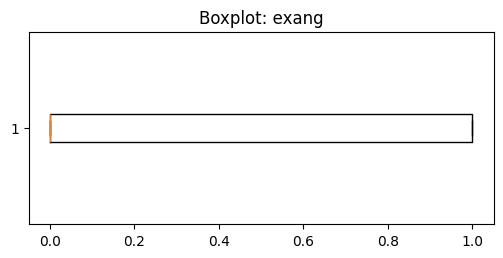

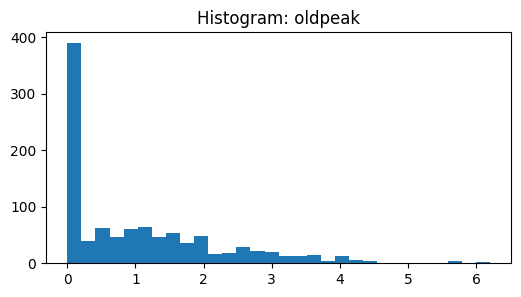

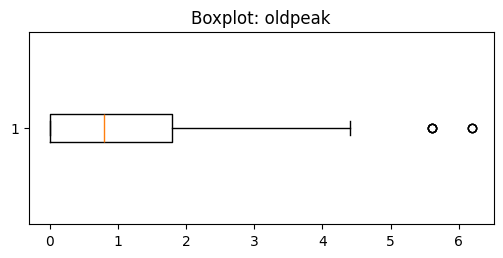

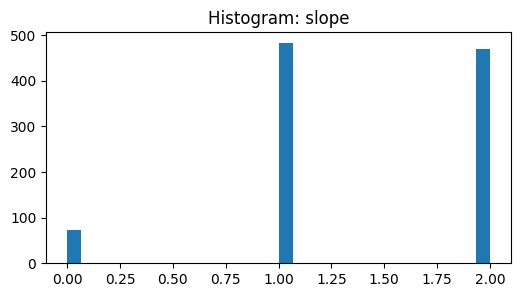

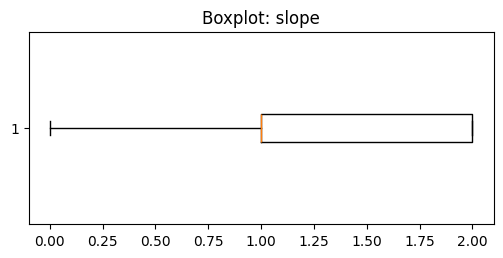

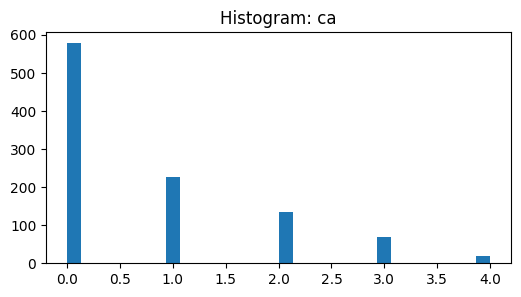

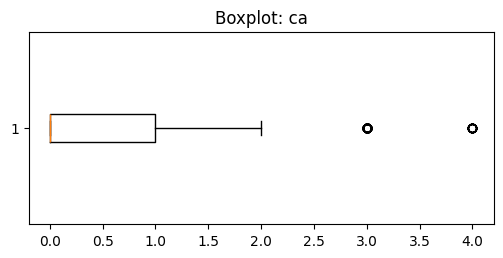

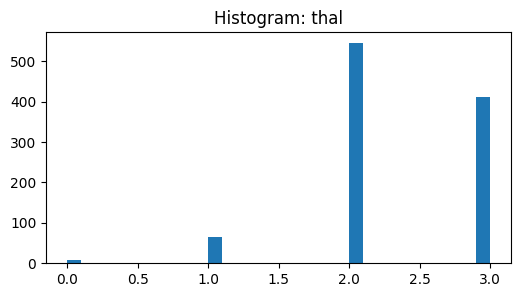

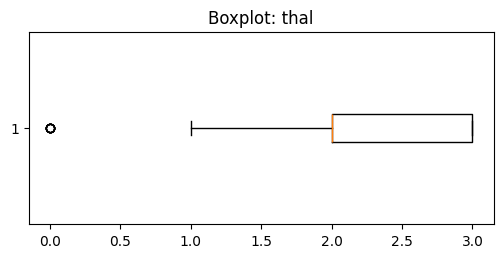

Top Pearson correlations with target:
 target      1.000000
cp          0.434854
thalach     0.422895
slope       0.345512
restecg     0.134468
fbs        -0.041164
chol       -0.099966
trestbps   -0.138772
age        -0.229324
sex        -0.279501
Name: target, dtype: float64


In [8]:
for c in num_cols:
    plt.figure(figsize=(6,3)); plt.hist(df[c].dropna(), bins=30); plt.title(f"Histogram: {c}"); plt.show()
    plt.figure(figsize=(6,2.5)); plt.boxplot(df[c].dropna(), vert=False); plt.title(f"Boxplot: {c}"); plt.show()

pearson = df[num_cols + [target_col]].corr(method="pearson")
spearman = df[num_cols + [target_col]].corr(method="spearman")
print("Top Pearson correlations with target:\n", pearson[target_col].sort_values(ascending=False).head(10))

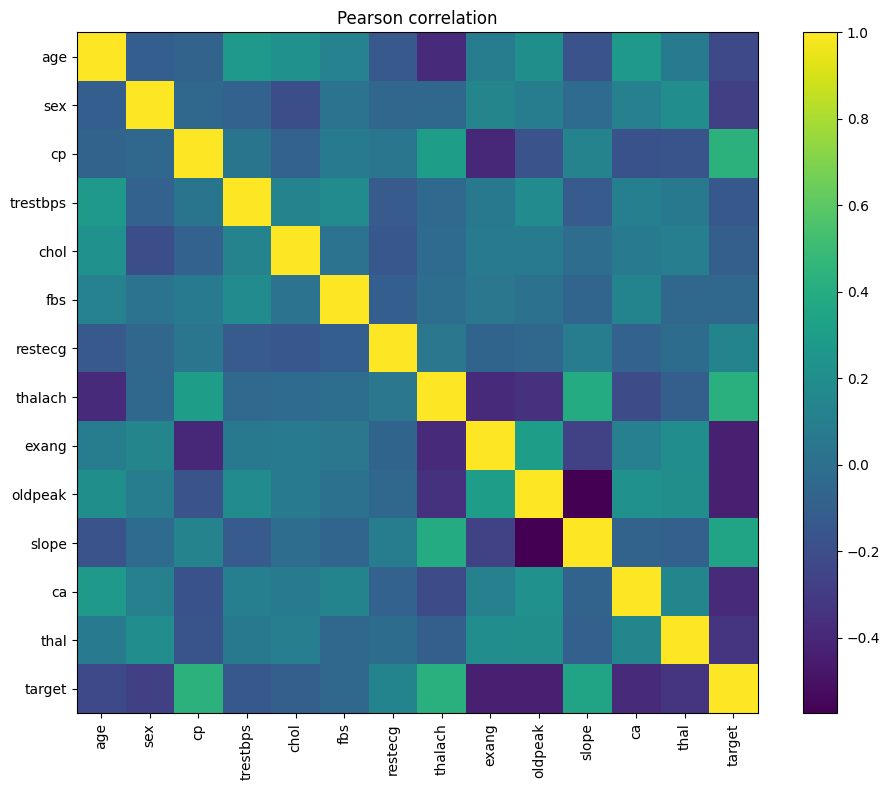

In [9]:
plt.figure(figsize=(10,8)); plt.imshow(pearson, interpolation='nearest'); plt.colorbar()
plt.xticks(range(len(pearson.columns)), pearson.columns, rotation=90)
plt.yticks(range(len(pearson.index)), pearson.index); plt.title("Pearson correlation"); plt.tight_layout(); plt.show()

<Axes: xlabel='age', ylabel='Count'>

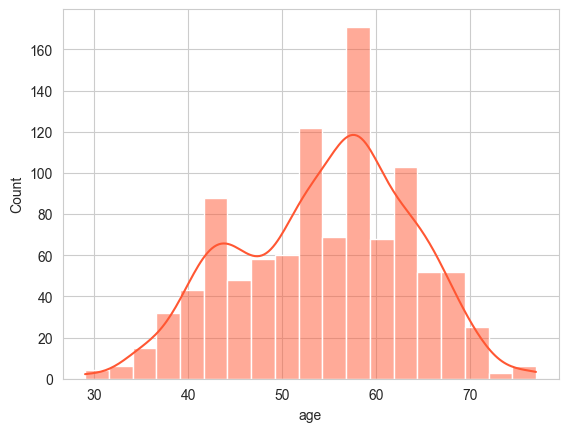

In [76]:
import seaborn as sns

# Define custom colors
custom_colors = ["#FF5733", "#3366FF", "#33FF57"]  # Example colors, you can adjust as needed

# Plot the histogram with custom colors
sns.histplot(df['age'], kde=True, color="#FF5733", palette=custom_colors)

Mean 54.43414634146342
Median 56.0
Mode 0    58
Name: age, dtype: int64


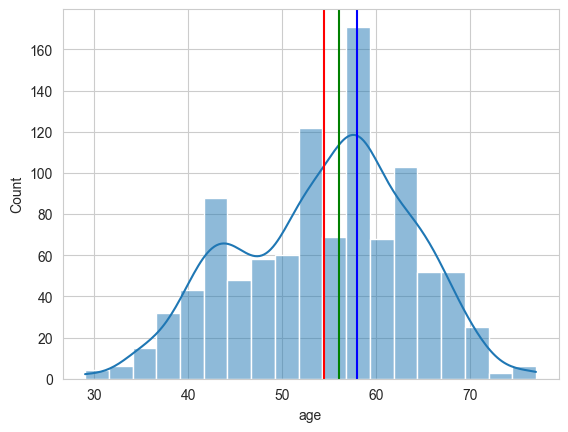

In [77]:
# Plot the mean, Median and mode of age column using sns
sns.histplot(df['age'], kde=True)
plt.axvline(df['age'].mean(), color='Red')
plt.axvline(df['age'].median(), color= 'Green')
plt.axvline(df['age'].mode()[0], color='Blue')

# print the value of mean, median and mode of age column
print('Mean', df['age'].mean())
print('Median', df['age'].median())
print('Mode', df['age'].mode())

<Axes: xlabel='cp', ylabel='count'>

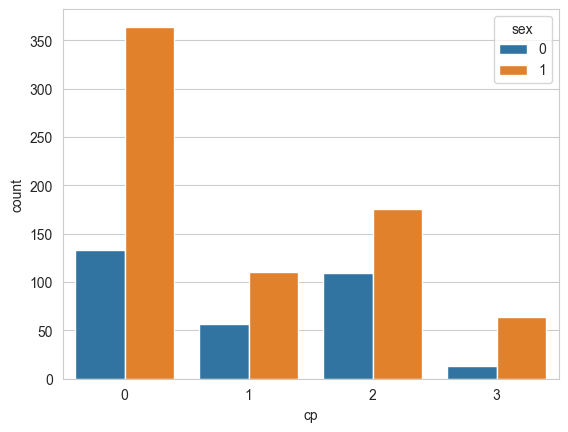

In [86]:
# count plot of cp column by sex column
sns.countplot(df, x='cp', hue= 'sex')

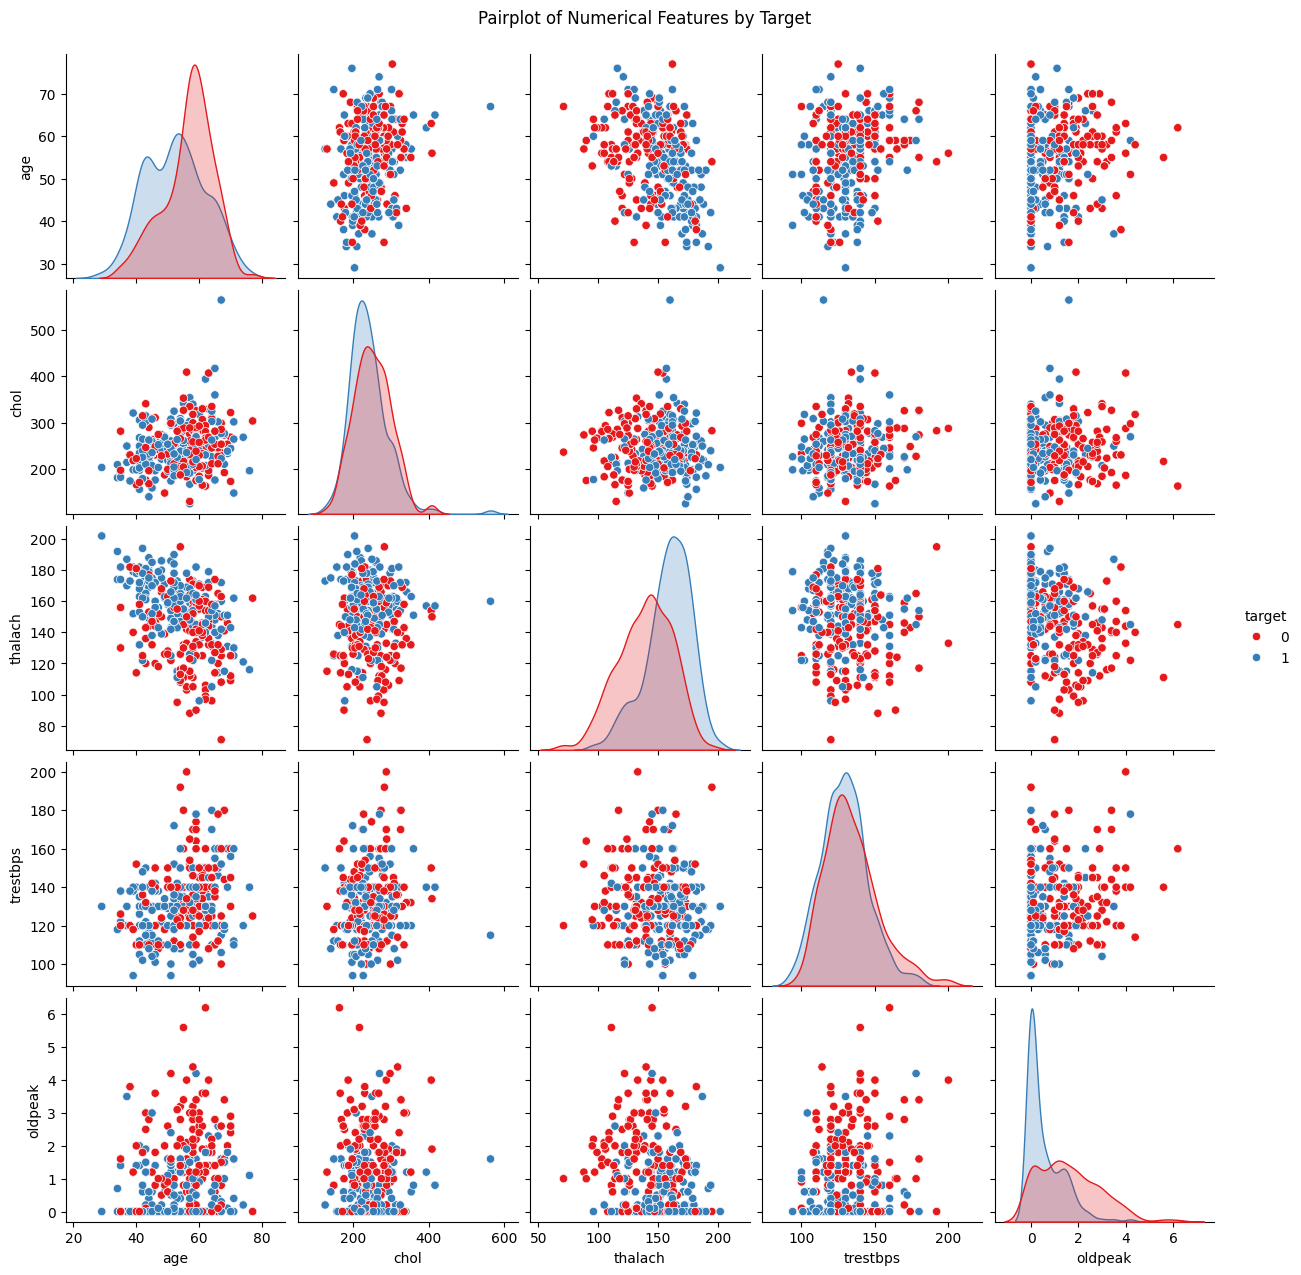

In [35]:
import seaborn as sns

# Subset only a few numerical features to avoid clutter
pairplot_cols = ["age", "chol", "thalach", "trestbps", "oldpeak", target_col]

sns.pairplot(df[pairplot_cols], hue=target_col, diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot of Numerical Features by Target", y=1.02)
plt.show()

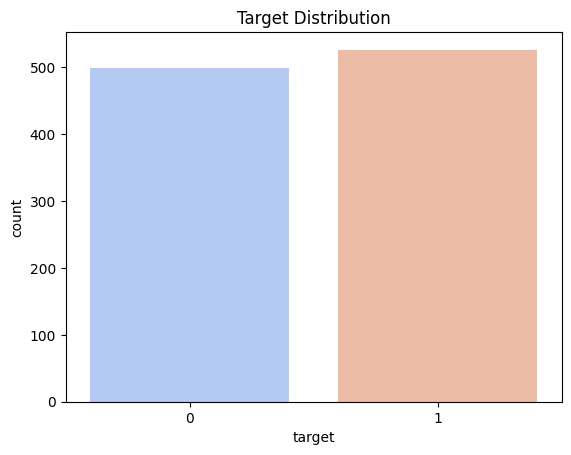

In [36]:
sns.countplot(x=target_col, data=df, palette="coolwarm")
plt.title("Target Distribution")
plt.show()


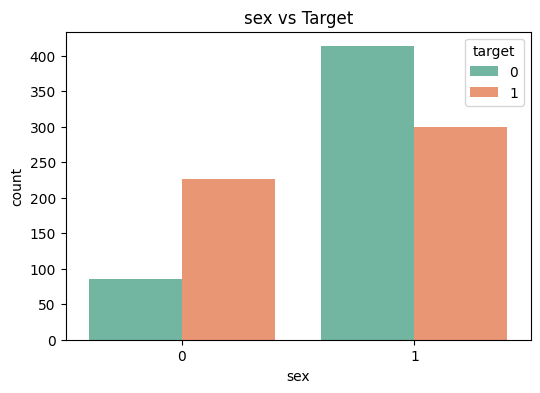

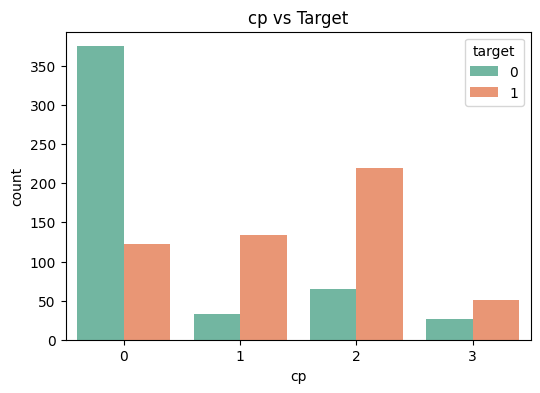

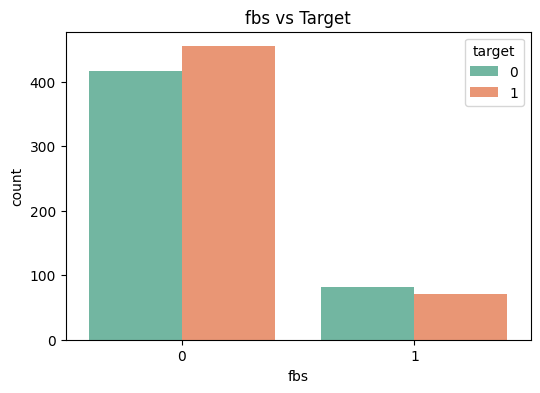

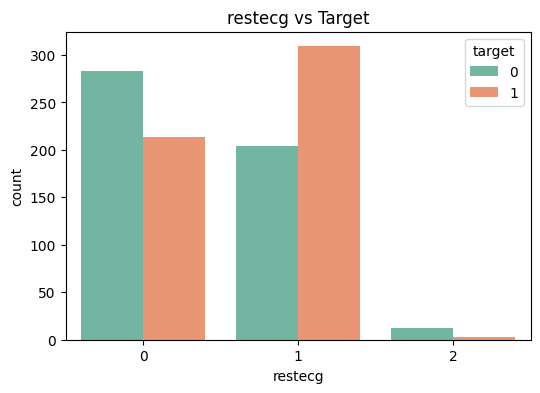

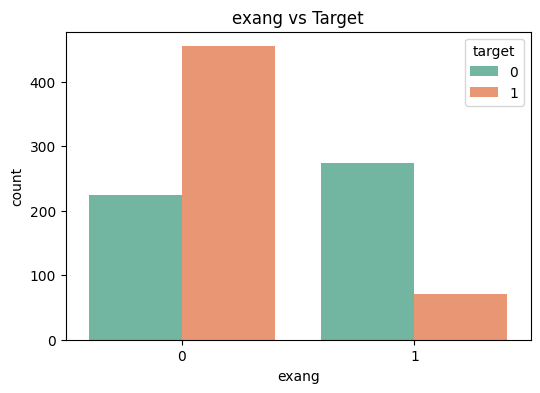

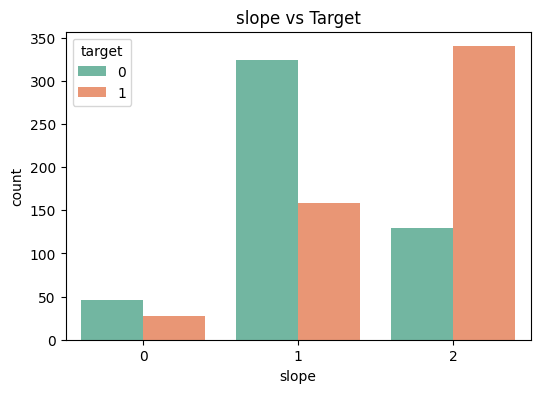

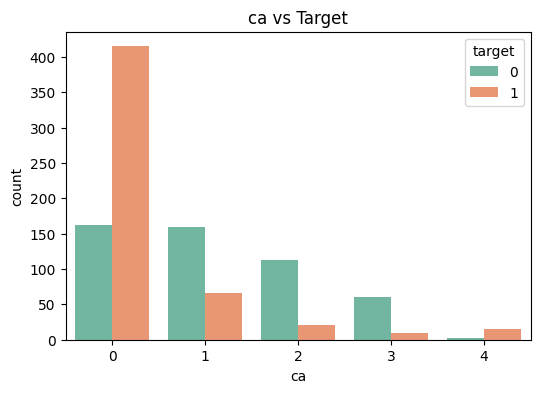

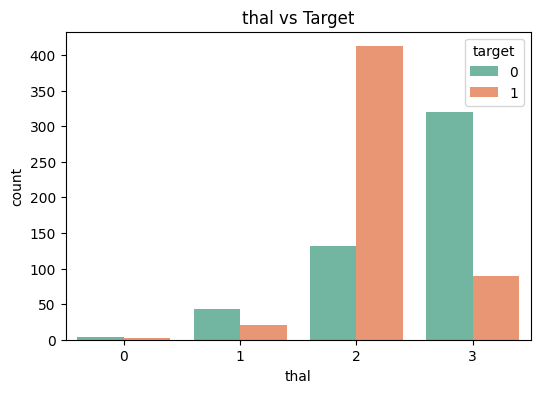

In [37]:
cat_features = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

for col in cat_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue=target_col, data=df, palette="Set2")
    plt.title(f"{col} vs Target")
    plt.show()


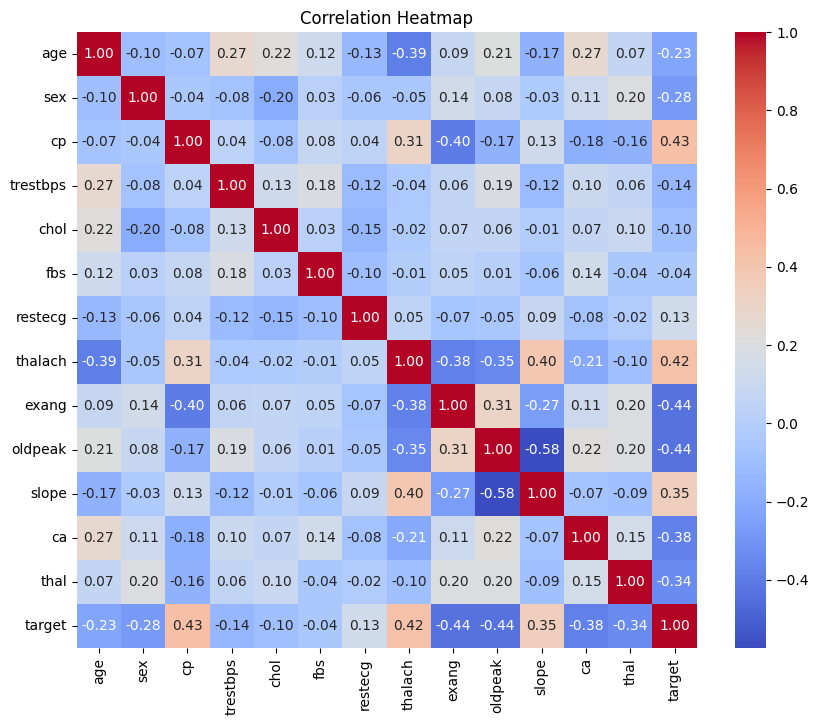

In [38]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


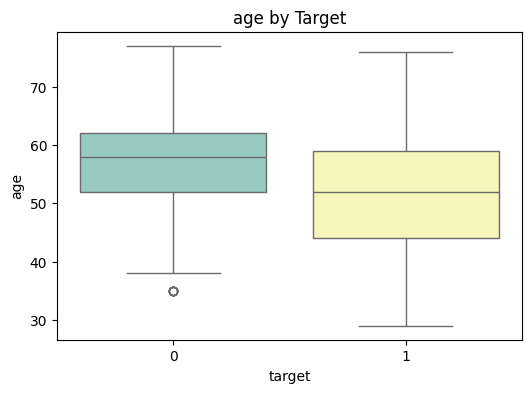

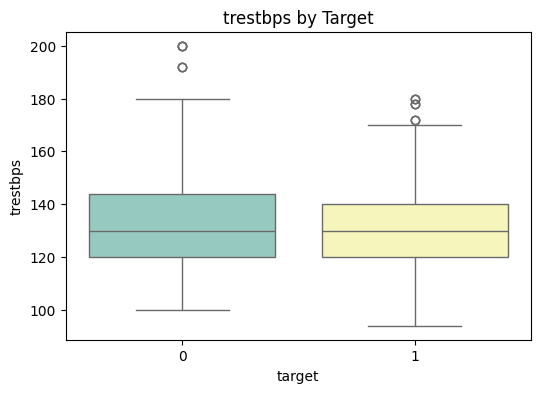

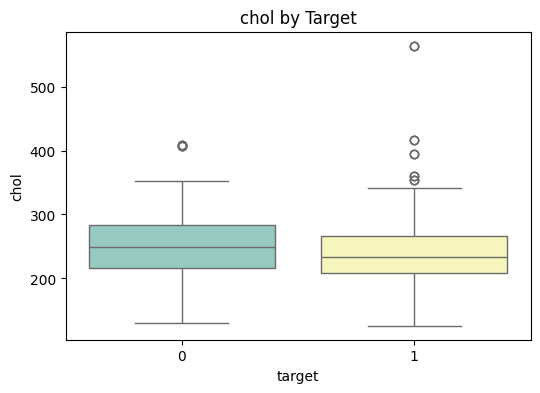

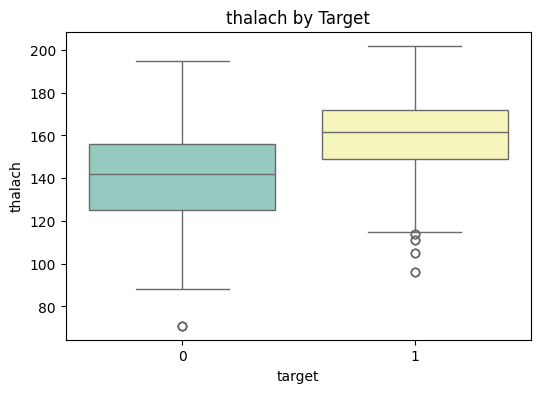

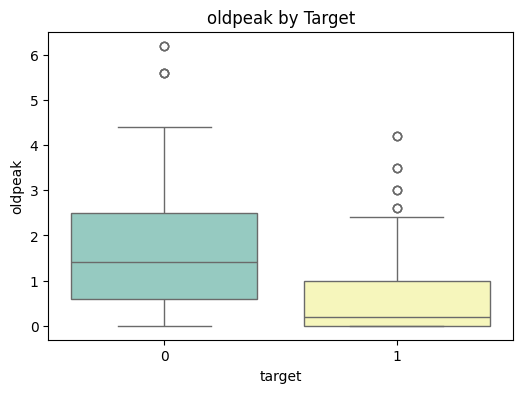

In [39]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y=col, data=df, palette="Set3")
    plt.title(f"{col} by Target")
    plt.show()


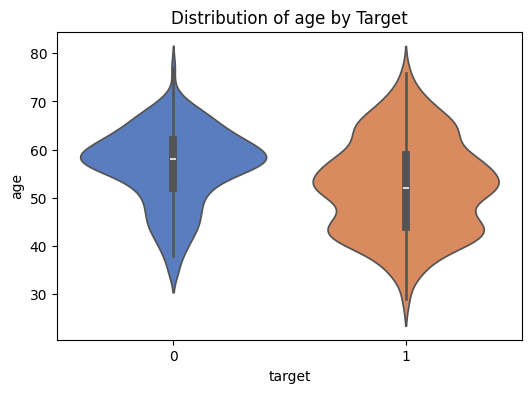

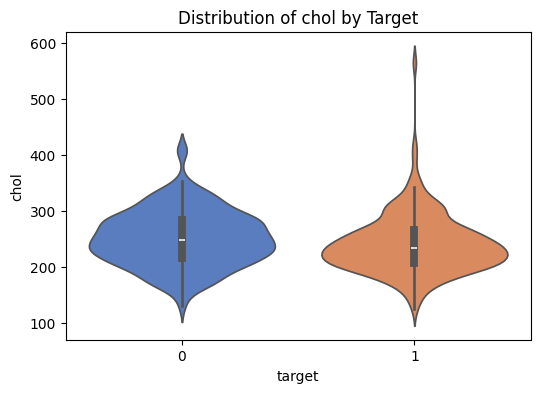

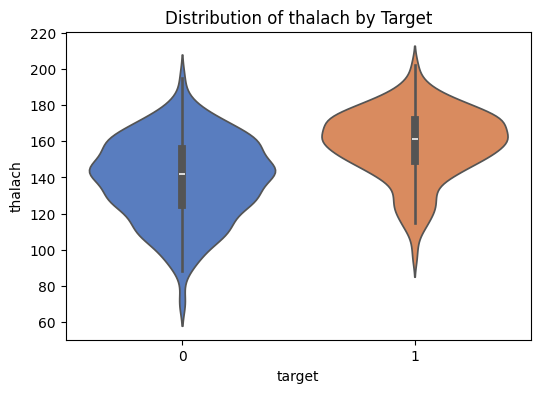

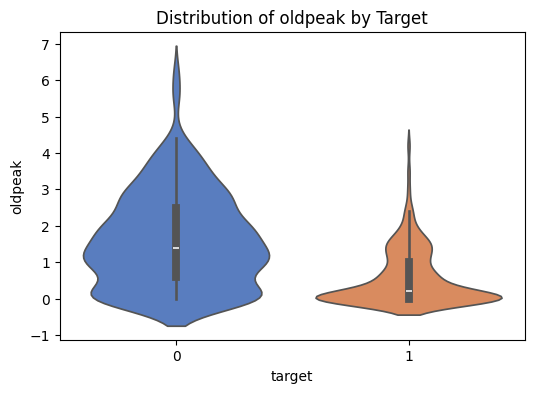

In [40]:
for col in ["age", "chol", "thalach", "oldpeak"]:
    plt.figure(figsize=(6,4))
    sns.violinplot(x=target_col, y=col, data=df, palette="muted")
    plt.title(f"Distribution of {col} by Target")
    plt.show()


# Preprocessing

In [11]:
# --- Preprocessing ---
X = df.drop(columns=[target_col])
y = df[target_col].copy()

# categorical detection: objects + small-cardinality ints
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in X.select_dtypes(include=[np.integer]).columns:
    if X[col].nunique() <= 6 and col not in cat_cols:
        cat_cols.append(col)
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)])

preprocessor = ColumnTransformer([("num", numeric_transformer, num_cols),
                                  ("cat", categorical_transformer, cat_cols)],
                                 remainder='drop')

X_processed = preprocessor.fit_transform(X)
ohe_names = []
if len(cat_cols) > 0:
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_cols + ohe_names
print("Processed shape:", X_processed.shape)

Processed shape: (1025, 30)


In [12]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# Decision Tree Classifier

In [14]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Decision Tree test acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Decision Tree test acc: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



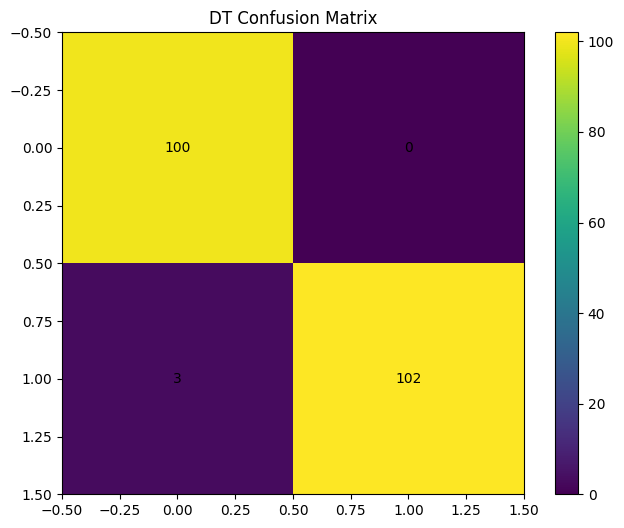

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6)); plt.imshow(cm); plt.title("DT Confusion Matrix"); plt.colorbar()
for (i,j),val in np.ndenumerate(cm): plt.text(j,i,val,ha='center',va='center')
plt.show()

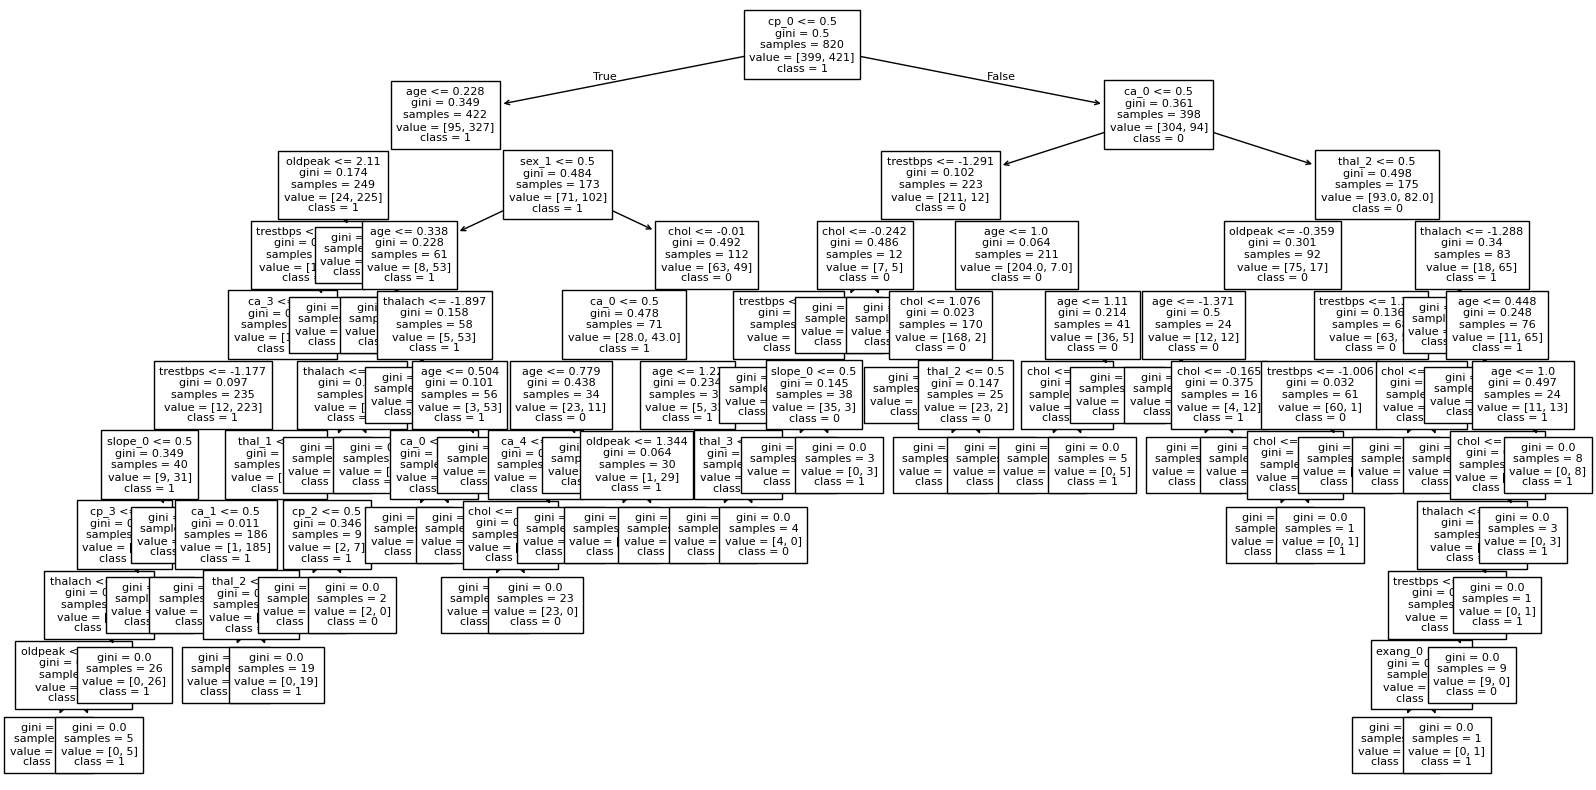

In [18]:
# Visualize tree (may be large & slow for unrestricted tree)
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=feature_names, class_names=[str(c) for c in np.unique(y)], filled=False, fontsize=8)
plt.show()

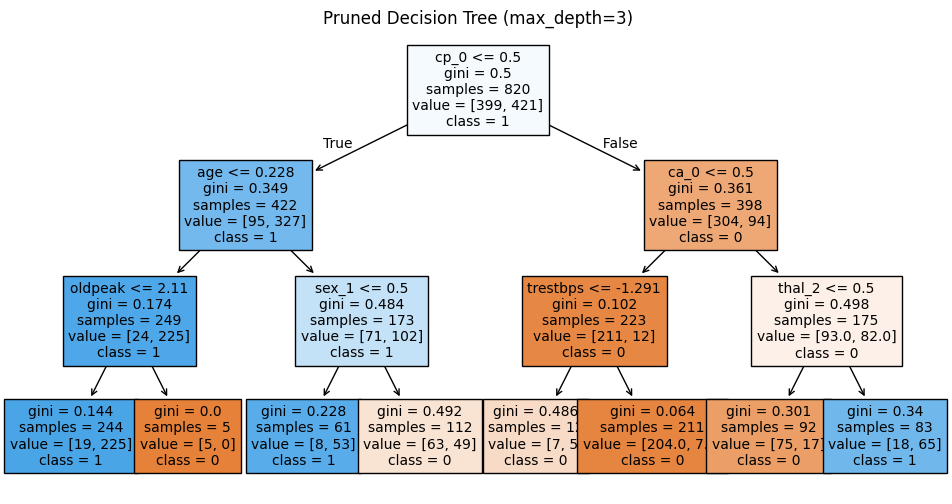

In [28]:
# After you trained preprocessor, dt_best etc. Use the processed "feature_names" list and dt_best or train a small tree:
small_dt = DecisionTreeClassifier(max_depth=3, random_state=42)
small_dt.fit(X_train, y_train)

plt.figure(figsize=(12,6))
plot_tree(small_dt, feature_names=feature_names, class_names=[str(c) for c in np.unique(y)], filled=True, fontsize=10)
plt.title("Pruned Decision Tree (max_depth=3)")
plt.show()

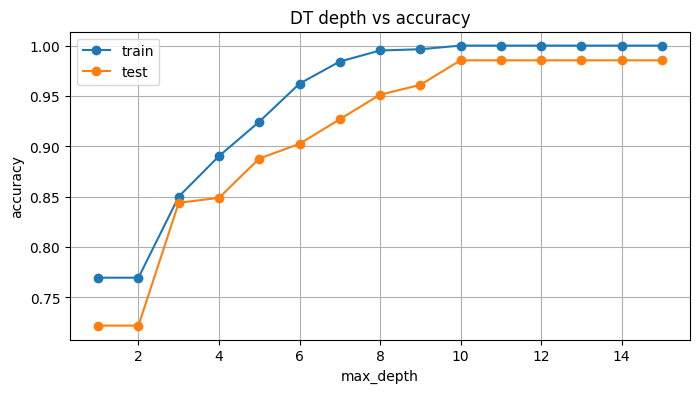

Best depth by test accuracy: 10


In [19]:
# --- Overfitting analysis: vary max_depth ---
depths = range(1,16)
train_acc=[]; test_acc=[]
for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=42)
    m.fit(X_train,y_train)
    train_acc.append(m.score(X_train,y_train))
    test_acc.append(m.score(X_test,y_test))

plt.figure(figsize=(8,4)); plt.plot(depths,train_acc,marker='o',label='train'); plt.plot(depths,test_acc,marker='o',label='test')
plt.xlabel("max_depth"); plt.ylabel("accuracy"); plt.legend(); plt.grid(True); plt.title("DT depth vs accuracy"); plt.show()
best_depth = depths[int(np.argmax(test_acc))]
print("Best depth by test accuracy:", best_depth)

In [20]:
# Retrain best-depth tree
dt_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_best.fit(X_train, y_train)
print("DT (best depth) test acc:", accuracy_score(y_test, dt_best.predict(X_test)))
print(classification_report(y_test, dt_best.predict(X_test)))


DT (best depth) test acc: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [21]:
# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("RF test acc:", accuracy_score(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))

RF test acc: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



,feature,importance_dt,importance_rf
7,cp_0,0.290159,0.093907
3,thalach,0.043824,0.092890
4,oldpeak,0.047780,0.085669
0,age,0.140953,0.080728
28,thal_2,0.089880,0.080021
21,ca_0,0.117450,0.074814
2,chol,0.102021,0.067222
29,thal_3,0.008368,0.058405
1,trestbps,0.051197,0.056224
16,exang_0,0.003254,0.044837


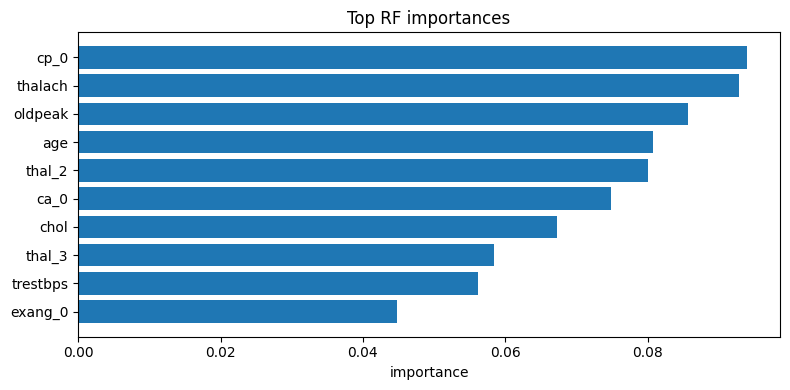

In [22]:
feat_imp_df = pd.DataFrame({"feature": feature_names,
                            "importance_dt": dt_best.feature_importances_,
                            "importance_rf": rf.feature_importances_}).sort_values("importance_rf", ascending=False)
display(feat_imp_df.head(15))

plt.figure(figsize=(8,4)); topn=10; top = feat_imp_df.head(topn).iloc[::-1]
plt.barh(top["feature"], top["importance_rf"]); plt.title("Top RF importances"); plt.xlabel("importance"); plt.tight_layout(); plt.show()

In [23]:
# --- Cross-validation (5-fold stratified) for DT_best and RF ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {"DecisionTree_best": DecisionTreeClassifier(max_depth=best_depth, random_state=42),
          "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)}
scoring = ["accuracy","precision","recall","f1","roc_auc"]
for name, model in models.items():
    print("\n", name)
    for s in scoring:
        try:
            scores = cross_val_score(model, X_processed, y, cv=skf, scoring=s)
            print(f"{s}: mean={scores.mean():.4f}, std={scores.std():.4f}")
        except Exception as e:
            print("skipping", s, e)


 DecisionTree_best
accuracy: mean=0.9961, std=0.0078
precision: mean=1.0000, std=0.0000
recall: mean=0.9924, std=0.0152
f1: mean=0.9961, std=0.0078
roc_auc: mean=0.9962, std=0.0076

 RandomForest
accuracy: mean=0.9961, std=0.0078
precision: mean=1.0000, std=0.0000
recall: mean=0.9924, std=0.0152
f1: mean=0.9961, std=0.0078
roc_auc: mean=1.0000, std=0.0000


In [26]:
feat_imp_df.to_csv("feature_importances.csv", index=False)
print("feature_importances.csv")

feature_importances.csv


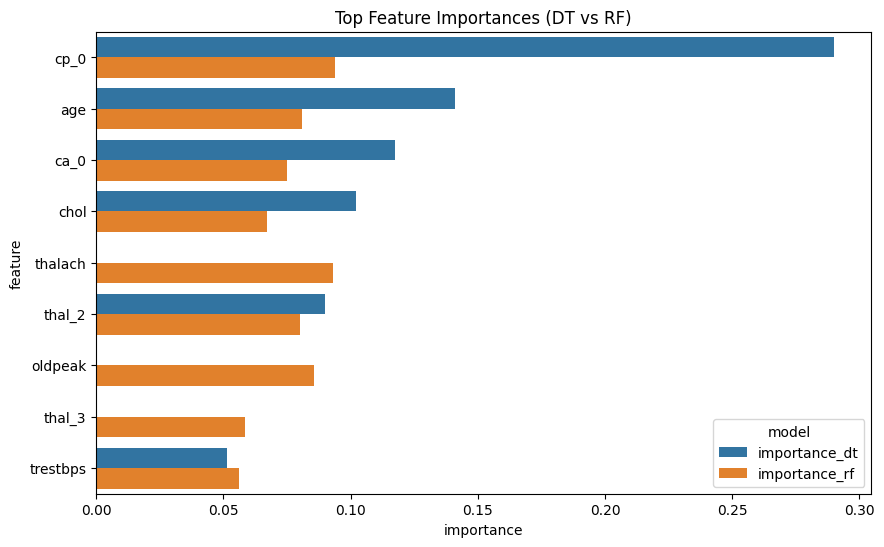

In [41]:
feat_imp_long = feat_imp_df.melt(id_vars="feature", value_vars=["importance_dt","importance_rf"],
                                 var_name="model", value_name="importance")

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", hue="model", data=feat_imp_long.sort_values("importance", ascending=False).head(15))
plt.title("Top Feature Importances (DT vs RF)")
plt.show()


<Figure size 600x600 with 0 Axes>

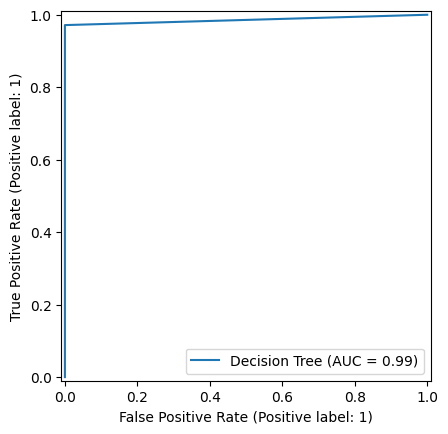

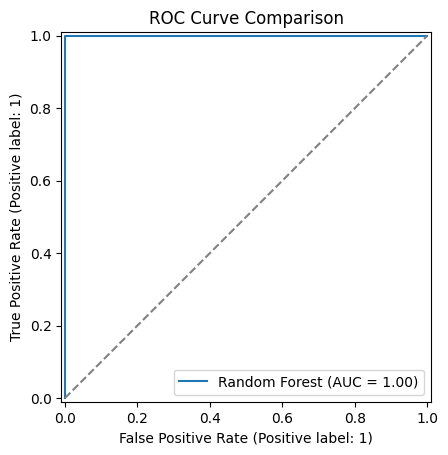

In [42]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,6))
RocCurveDisplay.from_estimator(dt_best, X_test, y_test, name="Decision Tree")
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="Random Forest")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison")
plt.show()


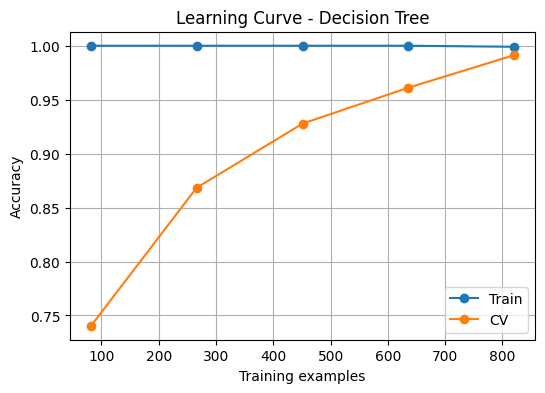

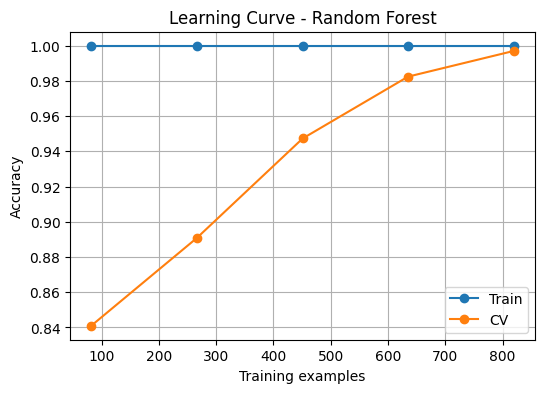

In [43]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_processed, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy"
    )
    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train")
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="CV")
    plt.title(title)
    plt.xlabel("Training examples"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)
    plt.show()

plot_learning_curve(dt_best, "Learning Curve - Decision Tree")
plot_learning_curve(rf, "Learning Curve - Random Forest")


# Using other models 

In [55]:


from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [56]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [60]:
y = data["target"]
X = data.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [61]:
print(y_test.unique())
Counter(y_train)

[1 0]


Counter({1: 419, 0: 401})

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[ 77  21]
 [  7 100]]


Accuracy of Logistic Regression: 86.34146341463415 

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        98
           1       0.83      0.93      0.88       107

    accuracy                           0.86       205
   macro avg       0.87      0.86      0.86       205
weighted avg       0.87      0.86      0.86       205



In [64]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

confussion matrix
[[79 19]
 [11 96]]


Accuracy of Naive Bayes model: 85.36585365853658 

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        98
           1       0.83      0.90      0.86       107

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.86      0.85      0.85       205



In [65]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[ 88  10]
 [  3 104]]


Accuracy of Random Forest: 93.65853658536587 

              precision    recall  f1-score   support

           0       0.97      0.90      0.93        98
           1       0.91      0.97      0.94       107

    accuracy                           0.94       205
   macro avg       0.94      0.93      0.94       205
weighted avg       0.94      0.94      0.94       205



In [66]:
m4 = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predicted))

confussion matrix
[[ 84  14]
 [  6 101]]


Accuracy of Extreme Gradient Boost: 90.2439024390244 

              precision    recall  f1-score   support

           0       0.93      0.86      0.89        98
           1       0.88      0.94      0.91       107

    accuracy                           0.90       205
   macro avg       0.91      0.90      0.90       205
weighted avg       0.90      0.90      0.90       205



In [67]:
m5 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[84 14]
 [11 96]]


Accuracy of K-NeighborsClassifier: 87.8048780487805 

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        98
           1       0.87      0.90      0.88       107

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205



In [68]:
m6 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

confussion matrix
[[95  3]
 [ 8 99]]


Accuracy of DecisionTreeClassifier: 94.6341463414634 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        98
           1       0.97      0.93      0.95       107

    accuracy                           0.95       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.95      0.95      0.95       205



In [69]:
m7 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))

confussion matrix
[[ 94   4]
 [  0 107]]


Accuracy of Support Vector Classifier: 98.04878048780488 

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        98
           1       0.96      1.00      0.98       107

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205



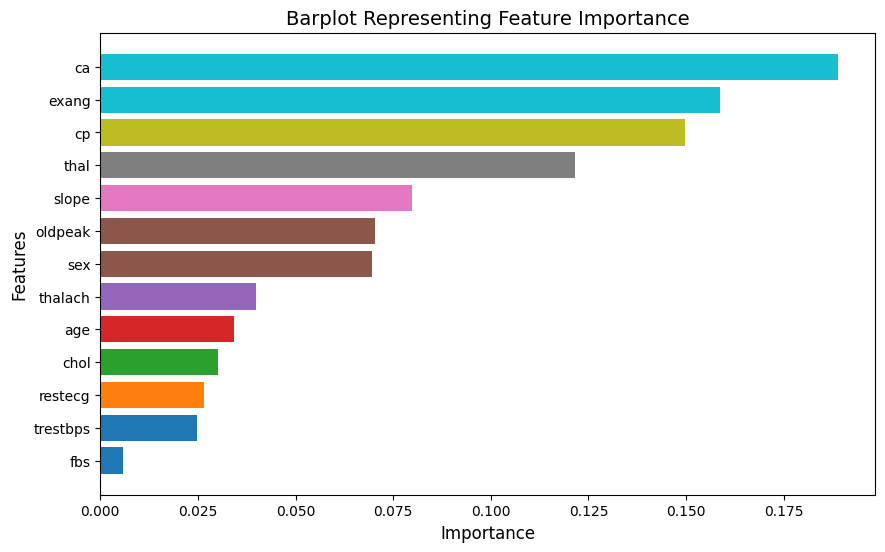

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Create DataFrame for feature importance
imp_feature = pd.DataFrame({
    'Feature': ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
                'exang', 'oldpeak', 'slope', 'ca', 'thal'],
    'Importance': xgb.feature_importances_
})

# Sort features by importance (optional but useful)
imp_feature = imp_feature.sort_values(by="Importance", ascending=True)

# Create color map
colors = cm.tab10(np.linspace(0, 1, len(imp_feature)))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(imp_feature['Feature'], imp_feature['Importance'], color=colors)
plt.title("Barplot Representing Feature Importance", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

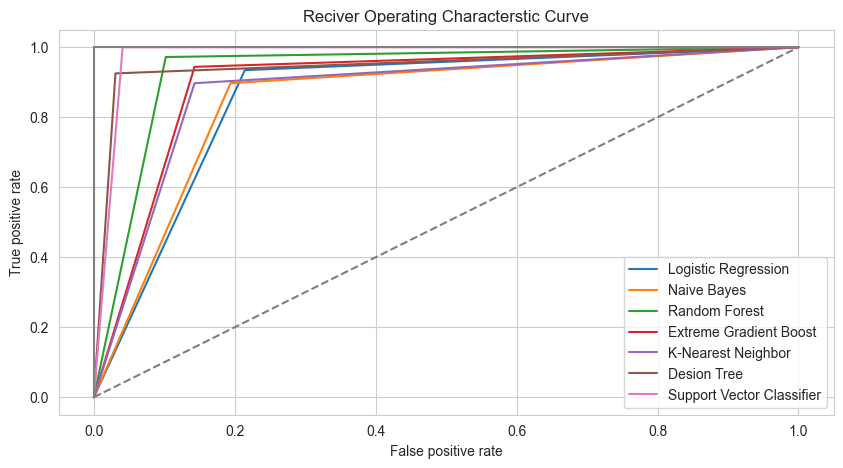

In [73]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nbpred)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted)                                                             
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_predicted)
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predicted)
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,dt_predicted)
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [74]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest','Extreme Gradient Boost',
                    'K-Nearest Neighbour','Decision Tree','Support Vector Machine'], 'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,xgb_acc_score*100,knn_acc_score*100,dt_acc_score*100,svc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,86.341463
1,Naive Bayes,85.365854
2,Random Forest,93.658537
3,Extreme Gradient Boost,90.243902
4,K-Nearest Neighbour,87.804878
5,Decision Tree,94.634146
6,Support Vector Machine,98.048780


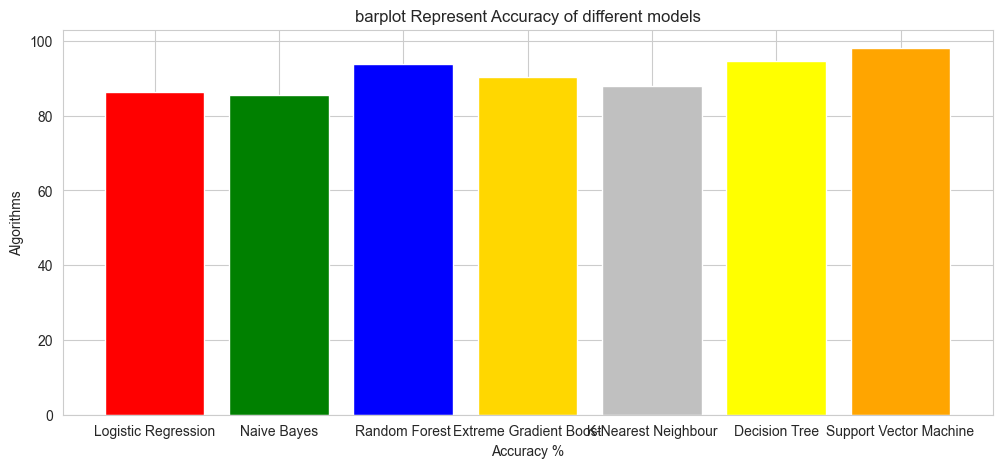

In [75]:
colors = ['red','green','blue','gold','silver','yellow','orange',]
plt.figure(figsize=(12,5))
plt.title("barplot Represent Accuracy of different models")
plt.xlabel("Accuracy %")
plt.ylabel("Algorithms")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()